In [1]:
import pickle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from util import cubic_transform, torch_interp
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset
import time
import pandas as pd
from astropy.timeseries import LombScargle
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [2]:
class SpectrumDataset(Dataset):

    """
    Classe de chargement et prétraitement des spectres du RV-DataChallenge Plato.

    Paramètres d'initialisation
    ----------------------------
    n_pixel : int
        Nombre d’échantillons sur la grille de longueurs d’onde (L).  
        Par défaut 2000.

    lambda_min, lambda_max : float ou None
        Bornes minimale et maximale du domaine spectral (en Å).  
        Si None, on utilise les valeurs extraites du spectre d’origine.  
        Par défaut 5000.0 – 5050.0 Å.

    precision : {'torch.float32', 'torch.float64'}
        Précision des tenseurs retournés par __getitem__ (utilisés lors de l'entraînement).

    Attributs internes accessibles
    ------------------------------
    n_spec, n_pixel : int
        Nombre de spectres et nombre de pixels par spectre.

    all_specs_numpy : ndarray, shape (n_spec, n_pixel), dtype float64
        Spectres bruts rééchantillonnés (ou non) sur la grille régulière.

    wave_numpy : ndarray, shape (n_pixel,), dtype float64
        Grille de longueurs d’onde.

    template_spec_numpy : ndarray, shape (n_pixel,), dtype float64
        Spectre « template » rééchantillonné.

    all_specs_torch32/64 : Tensor, shape [n_spec, n_pixel]
        Même données que all_specs_numpy, mais converties en float32 et float64.

    wave_torch32/64 : Tensor, shape [n_pixel]
        Même données que wave_numpy, converties en float32 et float64.

    template_spec_torch32/64 : Tensor, shape [n_pixel]
        Même données que template_spec_numpy, converties en float32 et float64.

    c : float
        Vitesse de la lumière (299 792 458 m/s).

    c_tensor : Tensor, shape [1], dtype float64
        Même valeur que c, en tenseur.

    wavelength_step : float
        Pas entre deux pixels consécutifs de la grille.

    all_augmented_specs_* : tensors / ndarray
        Versions « doppler-shiftées » agrégées (après appel à augment_data).

    Méthodes clés
    -------------
    __len__()
        Renvoie le nombre de spectres (n_spec).

    __getitem__(index)
        Retourne ((y_obs, y_aug, v_offset), index) selon self.precision.

    doppler_shift_batch(...)
        Applique un décalage doppler à un batch de spectres.

    plot_spec(...)
        Affiche un spectre (et optionnellement le template).

    plot_doppler(...)
        Affiche un spectre avant/après décalage doppler.

    augment_data(...)
        Génère automatiquement les spectres shiftés pour tout le dataset.
    """

    def __init__(
            self, n_pixel = 2000, 
            lambda_min=5000., 
            lambda_max=5050., 
            precision='torch.float32', 
            device='cpu',
            Kp = 10,
            P = 100
        ):

        # On charge le fichier Analyse_material, celui-ci contient le spectre template et la grille de longueur d'ondes
        with open('STAR1134_HPN_Analyse_material.p', 'rb') as f:
            analyse_material_data = pickle.load(f)

        wave_numpy = analyse_material_data['wave'].to_numpy(dtype='float64') # -> dtype=float64
        specs_numpy = np.load('STAR1134_HPN_flux_YVA.npy').astype('float64') # -> De taille (n_spec, n_pixel) / dtype=float64

        # On peut choisir de crop ou non le spectre sur certaines zones de longueur d'ondes
        if lambda_min is None:
            lambda_min = wave_numpy.min()
        if lambda_max is None:
            lambda_max = wave_numpy.max()

        # Mask pour crop
        wave_mask = (wave_numpy >= lambda_min) & (wave_numpy <= lambda_max)

        # On crop
        wave_numpy = wave_numpy[wave_mask]
        specs_numpy = specs_numpy[:, wave_mask]

        # On récupère le spectre template que l'on crop aussi
        template_spec_numpy = analyse_material_data['stellar_template'].to_numpy(dtype='float64') # -> dtype=float64
        template_spec_numpy = template_spec_numpy[wave_mask]

        # Réechantillonage des spectres sur une grille régulière si n_pixel est non nul ou non None
        if n_pixel:
            resampled_specs_numpy = []

            wave_new_numpy = np.linspace(lambda_min, lambda_max, n_pixel, dtype='float64') # Grille régulière
            for spec in specs_numpy:
                spec_resampled = np.interp(wave_new_numpy, wave_numpy, spec)
                resampled_specs_numpy.append(spec_resampled)
            
            resampled_specs_numpy = np.array(resampled_specs_numpy, dtype='float64')

            self.all_specs_numpy = resampled_specs_numpy
            self.wave_numpy = wave_new_numpy
            template_spec_numpy = np.interp(wave_new_numpy, wave_numpy, template_spec_numpy) # Réechantillonage du spectre template aussi
            self.template_spec_numpy = template_spec_numpy.astype('float64')

        else:
            # Sinon on garde les données initiales
            self.all_specs_numpy = specs_numpy
            self.wave_numpy = wave_numpy
            self.template_spec_numpy = template_spec_numpy

        self.device = device # Pour mettre ce qui est nécessaire sur GPU
        
        # Conversion en torch (dtype = float64)
        self.all_specs_torch64 = torch.from_numpy(self.all_specs_numpy).to(self.device, non_blocking=True)
        self.wave_torch64 = torch.from_numpy(self.wave_numpy).to(self.device, non_blocking=True)
        self.template_spec_torch64 = torch.from_numpy(self.template_spec_numpy).to(self.device, non_blocking=True)

        self.all_specs_torch32   = self.all_specs_torch64.to(torch.float32)
        self.wave_torch32        = self.wave_torch64.to(torch.float32)
        self.template_spec_torch32 = self.template_spec_torch64.to(torch.float32)

        # Données supplémentaires utiles sur le dataset:
        self.n_spec, self.n_pixel = self.all_specs_numpy.shape

        self.c = 299_792_458.0
        self.c_tensor = torch.tensor([299_792_458.0], dtype=torch.float64).to(self.device, non_blocking=True)

        self.precision = precision

        self.wavelength_step = (lambda_max - lambda_min) / (self.n_pixel - 1)

        self.all_augmented_specs_torch64 = None
        self.all_augmented_specs_torch32 = None
        self.all_augmented_specs_numpy = None

        self.all_voffsets64 = None
        self.all_voffsets32 = None

        self.Kp = Kp
        self.P = P
        self.jdb = pd.read_csv('STAR1134_HPN_Analyse_summary.csv')['jdb'].to_numpy()

        if self.Kp is not None and self.P is not None:
            self.inject_planetary_signal_in_data()
            
        self.augment_data(interp_method='torch_interp', batch_voffset=None)



    # Renvoie la longueur du dataset (n_spec)
    def __len__(self):
        return self.n_spec
    
    # Affiche les infos du dataset avec print()
    def __str__(self):
        return (f"-- Dataset de {self.n_spec} spectres de {self.n_pixel} pixels --\n-- λmin = {self.wave_numpy.min()}, λmax = {self.wave_numpy.max()} --\n-- Pas : {self.wavelength_step} λ --")
    
    def __getitem__(self, index):
        if self.precision == 'torch.float64':
            batch_yobs = self.all_specs_torch64[index, :] # Renvoie un batch [B, n_pixel] dtype = torch.float32
            batch_yaug = self.all_augmented_specs_torch64[index, :] # Renvoie un batch [B, n_pixel] dtype = torch.float32
            batch_voffset = self.all_voffsets64[index]

        else:
            batch_yobs = self.all_specs_torch32[index, :] # Renvoie un batch [B, n_pixel] dtype = torch.float32
            batch_yaug = self.all_augmented_specs_torch32[index, :] # Renvoie un batch [B, n_pixel] dtype = torch.float32
            batch_voffset = self.all_voffsets32[index]
            
        return (batch_yobs, batch_yaug, batch_voffset), index

    # Shift un batch de spectre avec un batch de vitesses d'offset données
    def doppler_shift_batch(self, batch_yobs, batch_voffset, interp_method='torch_interp', out_dtype='torch.float32'):
        """
            Simule un shift doppler pour un batch de spectre de dim [B, n_pixel] et un batch de vitesse d'offset de taille [B, 1]
            Retourne un batch de spectres augmentés de taille [B, n_pixel]

            On dispose de différentes d'interpolation : 

             * torch_interp -> Méthode linéaire parrallélisée -> gain de perf
             * cubic_transform -> Le plus lent, Méthode utilisée par AESTRA

        """

        # Méthode parallélisée -> interpolation linéaire et valeurs de frontières fixées constantes
        if interp_method == 'torch_interp':

            # On travaille par batch
            B = batch_yobs.shape[0]
            
            batch_wave = self.wave_torch64.unsqueeze(0) # [n_pixel] -> [1, n_pixel]
            batch_wave = batch_wave.expand(B, -1) # [B, n_pixel]
            batch_wave = batch_wave

            if batch_voffset.dtype != 'torch.float64':
                batch_voffset = batch_voffset.double()

            if batch_yobs.dtype != 'torch.float64':
                batch_yobs = batch_yobs.double()

            batch_doppler_factor = torch.sqrt( (1 + batch_voffset/self.c_tensor) /  (1 - batch_voffset/self.c_tensor)) # [B, 1]
            
            # Pour vérifier si le facteur gamma ne vaut pas bêtement 1 pour cause de précision
            # print('Valeur du facteur gamma : ', batch_doppler_factor[0].item()) 

            batch_wave_shifted = batch_wave * batch_doppler_factor # [B, n_pixel] * [B, 1] (Ressort en float64)

            batch_yaug = torch_interp(batch_wave, batch_wave_shifted, batch_yobs) # [B, n_pixel] en float64

            if out_dtype == 'torch.float64':
                return batch_yaug.double() 
            else:
                return batch_yaug.float() 
        
        # Méthode utilisée dans AESTRA -> un peu plus rapide que scipy.interpolate.interp1d() sur de gros batch > 1000 mais sinon très lent
        elif interp_method == 'cubic_transform':
           
            # Cubic transform attend 3 arguments : 
            #   - x_rest = tenseur de la grille de longueurs d'onde de taille    [n_pixel]
            #   - y_rest = batch de spectres de taille                           [B, n_pixel]
            #   - wave_shifted = batch des grilles de longueurs d'onde shiftée   [B, n_pixel] 
            

            # On travaille par batch
            B = batch_yobs.shape[0]

            batch_wave = self.wave_torch64.unsqueeze(0) # [n_pixel] -> [1, n_pixel]
            batch_wave = batch_wave.expand(B, -1) # [B, n_pixel]
            batch_wave = batch_wave

            if batch_voffset.dtype != 'torch.float64':
                batch_voffset = batch_voffset.double()

            if batch_yobs.dtype != 'torch.float64':
                batch_yobs = batch_yobs.double()

            batch_doppler_factor = torch.sqrt( (1 - batch_voffset/self.c_tensor) /  (1 + batch_voffset/self.c_tensor)) # [B, 1]
            
            batch_wave_shifted = batch_wave * batch_doppler_factor # [B, n_pixel]

            batch_yaug = cubic_transform(
                xrest=self.wave_torch64,
                yrest=batch_yobs,
                wave_shifted=batch_wave_shifted
            )

            if out_dtype == 'torch.float64':
                return batch_yaug.double() 
            else:
                return batch_yaug.float() 
            
    # Plot un spec du dataset
    def plot_spec(self, index = None, with_template=False):
        
        # Si on ne précise pas quel spectre plot on en prend un au hasard
        if index is None:
            index = np.random.randint(0, self.n_spec)
        
        spec_to_plot = self.all_specs_numpy[index, :]

        plt.figure(figsize=(18, 6))
        plt.title('Exemple de spectre')
        if with_template:
            plt.plot(self.wave_numpy, self.template_spec_numpy, linestyle='dashed', color='grey', label='Template')
        plt.plot(self.wave_numpy, spec_to_plot, label=f'Spectre n°{index}')
        plt.legend()
        plt.grid(alpha=0.5)
        plt.show()

        plt.figure(figsize=(18, 6))
        plt.title('(Zoom) Exemple de spectre')
        if with_template:
            plt.plot(self.wave_numpy, self.template_spec_numpy, linestyle='dashed', color='grey', label='Template')
        plt.plot(self.wave_numpy, spec_to_plot, label=f'Spectre n°{index}')
        plt.xlim(5012, 5013)
        plt.legend()
        plt.grid(alpha=0.5)
        plt.show()

    # Plot un spec du dataset ainsi qu'un shift doppler pur de celui-ci
    def plot_doppler(self, index = None, v_offset=950, plot_edges=False, interp_method='np.interp'):
        if index is None:
            index = np.random.randint(0, self.n_spec)
        
        spec_to_plot = self.all_specs_numpy[index, :]
        
        # Il faut le mettre sous forme de batch pour le rentrer dans la fonction doppler_shift_batch
        batched_spec_to_plot = self.all_specs_torch64[index, :].unsqueeze(0) # Le unsqueeze rajoute la dimension du batch au début 
        batched_voffset = torch.tensor([v_offset]).unsqueeze(0) # Le unsqueeze rajoute la dimension du batch au début 

        batch_yaug = self.doppler_shift_batch(batched_spec_to_plot, batched_voffset, interp_method)

        shifted_spec_to_plot = batch_yaug.cpu().squeeze().numpy()

        plt.figure(figsize=(18, 6))
        plt.title(f'Exemple de spectre shifté v={v_offset} m/s')
        plt.plot(self.wave_numpy, spec_to_plot, label='Spectre original')
        plt.plot(self.wave_numpy, shifted_spec_to_plot, label=f'Spectre Shifté voffset = {v_offset}')
        plt.legend()
        plt.grid(alpha=0.5)
        plt.show()

        # L'interpolation peut causer des problèmes au niveau des bords : plot_edges permet de visualiser les 10 premiers/derniers points
        if plot_edges:
            plt.figure(figsize=(18, 6))
            plt.title(f'(Zoom) Bord Gauche v={v_offset} m/s')
            plt.plot(self.wave_numpy, spec_to_plot, label='Spectre original', marker="x")
            plt.plot(self.wave_numpy, shifted_spec_to_plot, label=f'Spectre Shifté voffset = {v_offset}', marker="o")
            plt.xlim(self.wave_numpy.min() - 1 * self.wavelength_step, self.wave_numpy.min() + 10 * self.wavelength_step)
            plt.legend()
            plt.grid(alpha=0.5)
            plt.show()

            plt.figure(figsize=(18, 6))
            plt.title(f'(Zoom) Bord Droit v={v_offset} m/s')
            plt.plot(self.wave_numpy, spec_to_plot, label='Spectre original', marker="x")
            plt.plot(self.wave_numpy, shifted_spec_to_plot, label=f'Spectre Shifté voffset = {v_offset}', marker="o")
            plt.xlim(self.wave_numpy.max() - 10 * self.wavelength_step, self.wave_numpy.max() + 1 * self.wavelength_step)
            plt.legend()
            plt.grid(alpha=0.5)
            plt.show()
    
    def augment_data(self, interp_method='torch_interp', batch_voffset=None):
        if batch_voffset is None:
            batch_voffset = torch.rand(size=(self.n_spec, 1), dtype=torch.float64, device=self.device)* 6 - 3 # Distrib uniforme entre -3 et 3

        self.all_augmented_specs_torch32 = self.doppler_shift_batch(
            batch_yobs    = self.all_specs_torch64,  # On interpole sur tout les spectres
            batch_voffset = batch_voffset,
            interp_method = interp_method,
            out_dtype     = 'torch.float32'
            )
        
        self.all_augmented_specs_torch64 = self.doppler_shift_batch(
            batch_yobs    = self.all_specs_torch64,  # On interpole sur tout les spectres
            batch_voffset = batch_voffset,
            interp_method = interp_method,
            out_dtype     = 'torch.float64'
            )
        
        self.all_augmented_specs_numpy = self.all_augmented_specs_torch64.cpu().numpy()

        self.all_voffsets64 = batch_voffset
        self.all_voffsets32 = batch_voffset.float()

        print('Dataset augmenté !')

    def inject_planetary_signal_in_data(self, interp_method='torch_interp'):
        t = torch.tensor(self.jdb).unsqueeze(-1).to(self.device) # On récupère le vecteur temps [n_spec, 1]
        
        batch_voffset = self.Kp * torch.sin(t * 2*torch.pi / self.P) + 3 * torch.sin(t * 2*torch.pi / 65)
        
        self.all_specs_torch32 = self.doppler_shift_batch(
            batch_yobs    = self.all_specs_torch64,  # On interpole sur tout les spectres
            batch_voffset = batch_voffset,
            interp_method = interp_method,
            out_dtype     = 'torch.float32'
            )
        
        self.all_specs_torch64 = self.doppler_shift_batch(
            batch_yobs    = self.all_specs_torch64,  # On interpole sur tout les spectres
            batch_voffset = batch_voffset,
            interp_method = interp_method,
            out_dtype     = 'torch.float64'
            )
        
        print('Signal planétaire injecté !')
        



In [3]:
class MLP(nn.Module):
    """
        Réseau Multi-Perceptron classique
    """
    def __init__(
        self, 
        n_in, 
        n_out, 
        n_hidden=(16, 16, 16),
        act=(nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()),
        dropout=0
    ):
        super(MLP, self).__init__()
        
        n_ = [n_in, *n_hidden, n_out]
        
        layers = []
        
        for i in range(0, len(n_)-1):
            layers.append(nn.Linear(in_features=n_[i], out_features=n_[i+1]))
            layers.append(act[i])
            layers.append(nn.Dropout(p=dropout))
            
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)
    
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_ksize,
        conv_stride,
        conv_padding,
        maxpool_ksize,
        maxpool_stride,
        maxpool_padding,
        maxpool_ceil_mode,
        act=nn.LeakyReLU(),
        dropout=0,
        
    ):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=conv_ksize, 
            stride=conv_stride, 
            padding=conv_padding
        )
        
        self.instancenorm = nn.InstanceNorm1d(num_features=out_channels)
        
        self.activation = act
        self.dropout = nn.Dropout(p=dropout)
        
        # Si on veut rajouter une couche maxpool (pas le cas du dernier convblock de spender)
        if (maxpool_ksize is not None) and (maxpool_padding is not None) and (maxpool_stride is not None) and (maxpool_ceil_mode is not None):
            self.maxpool = nn.MaxPool1d(
                kernel_size=maxpool_ksize, 
                stride=maxpool_stride, 
                padding=maxpool_padding,
                ceil_mode=maxpool_ceil_mode
            )
        else:
            self.maxpool = None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        
        if self.maxpool is not None:
            x = self.maxpool(x)
        
        return x
    
class SPENDER(nn.Module):
    """
    
        * self.n_pixel_in              -> Nb de pixel du spectre en entrée           dtype=int
        
        * self.wave_block          -> tensor de taille [B, n_pixel_in]           dtype=float32
        
    """
    def __init__(self, n_pixel_in):
        super(SPENDER, self).__init__()
        
        # ---------- Encoder ----------
        
        # ConvBlock n°1
        self.convblock1 = ConvBlock(
            in_channels=1,
            out_channels=128,
            
            conv_ksize=5,
            conv_stride=1,
            conv_padding=2,
            
            maxpool_ksize=5,
            maxpool_stride=5,
            maxpool_padding=0,
            maxpool_ceil_mode=True,
            
            act=nn.PReLU(num_parameters=128),
            dropout=0
        )
        
        # ConvBlock n°2
        self.convblock2 = ConvBlock(
            in_channels=128,
            out_channels=256,
            
            conv_ksize=11,
            conv_stride=1,
            conv_padding=5,
            
            maxpool_ksize=11,
            maxpool_stride=11,
            maxpool_padding=0,
            maxpool_ceil_mode=True,
            
            act=nn.PReLU(num_parameters=256),
            dropout=0
        )
        
        # ConvBlock n°3
        self.convblock3 = ConvBlock(
            in_channels=256,
            out_channels=512,
            
            conv_ksize=21,
            conv_stride=1,
            conv_padding=10,
            
            maxpool_ksize=None,
            maxpool_stride=None,
            maxpool_padding=None,
            maxpool_ceil_mode=None,
            
            act=nn.PReLU(num_parameters=512),
            dropout=0
        )
        
        # Softmax du bloc d'attention
        self.softmax = nn.Softmax(dim=-1)
        
        # MLP pour convertir la sortie de l'attention block en vecteur de l'espace latent
        self.latentMLP = MLP(
            n_in=256,
            n_out=3,
            n_hidden=(128, 64, 32),
            act=(nn.PReLU(128), nn.PReLU(64), nn.PReLU(32), nn.PReLU(3)),
            dropout=0
        )
        
        # ---------- Decoder ----------
        self.decoder = MLP(
            n_in=3,
            n_out=n_pixel_in,
            n_hidden=(64, 256, 1024),
            act=(nn.PReLU(64), nn.PReLU(256), nn.PReLU(1024), nn.PReLU(n_pixel_in)),
            dropout=0
        )
        
        self.LSF = nn.Conv1d(1, 1, 5, bias=False, padding='same')

        self.current_latent = None

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Encoding
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        C = x.shape[1] // 2 # Nombre de canaux
        h, k = torch.split(x, [C, C], dim=1) # On divise en deux
        a = self.softmax(k)
        e = torch.sum(h * a, dim=-1) # On somme selon les longueurs d'ondes -> sortie [B, C]
        s = self.latentMLP(e) # Vecteur latent

        self.current_latent = s
        
        # Decoding
        x = self.decoder(s)

        x = x.unsqueeze(1)
                
        # Convolve
        x = self.LSF(x)

        x = x.squeeze(1)

        return x

In [4]:
class RVEstimator(nn.Module):
    """Some Information about RVEstimator"""
    def __init__(
        self,
        n_pixel_in,
        dropout=0
                 ):
        super(RVEstimator, self).__init__()
                
        # ConvBlock n°1
        self.convblock1 = ConvBlock(
            in_channels=1,
            out_channels=128,
            
            conv_ksize=5,
            conv_stride=1,
            conv_padding=2,
            
            maxpool_ksize=5,
            maxpool_stride=5,
            maxpool_padding=0,
            maxpool_ceil_mode=False,
            
            act=nn.PReLU(num_parameters=128),
            dropout=0
        )
        
        # ConvBlock n°2
        self.convblock2 = ConvBlock(
            in_channels=128,
            out_channels=64,
            
            conv_ksize=10,
            conv_stride=1,
            conv_padding=5,
            
            maxpool_ksize=10,
            maxpool_stride=10,
            maxpool_padding=0,
            maxpool_ceil_mode=False,
            
            act=nn.PReLU(num_parameters=64),
            dropout=0
        )
        
        self.n_features_out = 64 * (n_pixel_in // 5) // 10
        
        # print(self.n_features_out)
        
        self.softmax = nn.Softmax(dim=-1)
        
        self.flatten = nn.Flatten() # Entrée de la taille [B, C, L] avec B = taille du batch, C = nb de canaux et L = segments wavelength
        self.mlp = MLP(
            n_in = self.n_features_out,
            n_out = 1,
            n_hidden=(128, 64, 32),
            act=(nn.PReLU(128), nn.PReLU(64), nn.PReLU(32), nn.Identity()),
            dropout=dropout
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.softmax(x)
        x = self.flatten(x)
        x = self.mlp(x)

        return x

In [8]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- Hyperparamètres ----------- 

B = 64
n_epochs = 100
learning_rate = 1e-4

lambda_min = 5000
lambda_max = 5050
n_pixel = 2000 # = n_pixel
precision = 'torch.float32'

# LRV
sigmav = 0.3

# Lreg
sigmay = 0.1
k_reg = 0

# ----------- Dataset -----------

dataset = SpectrumDataset(n_pixel, lambda_min, lambda_max, precision=precision, device=device)

train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))

train_set, test_set = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=B, shuffle=False)
test_dataloader  = DataLoader(test_set,  batch_size=B, shuffle=False)

spec_template = dataset.template_spec_torch32
n_pixel = dataset.n_pixel

# ----------- Model -----------

rvestimator = RVEstimator(n_pixel_in=n_pixel, dropout=0.)
rvestimator_optimizer = torch.optim.Adam(
    params=rvestimator.parameters(), 
    lr=learning_rate)

spender = SPENDER(n_pixel_in=n_pixel)

b_rest = nn.Parameter(torch.randn(size=(1, n_pixel)))

aestra_optimizer = torch.optim.Adam(
    params=list(rvestimator.parameters()) + list(spender.parameters()) + [b_rest],
    lr=learning_rate
)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(rvestimator_optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=n_epochs)
interp_method = 'torch_interp'

# On met template_spec_torch sous forme de tenseur [1, n_pixel] pour profiter du broadcasting sans avoir à dupliquer
b_obs = spec_template.unsqueeze(0)

# ----------- GPU -----------

rvestimator = rvestimator.to(device)
spender     = spender.to(device)
b_rest.data = b_rest.data.to(device)
b_obs = b_obs.to(device)

start_time = time.time()
for t in range(1, n_epochs + 1):
    
    print(f'--- Epoch {t} ---')
    # -------------- Train --------------
 
    rvestimator.train()
    spender.train()
    train_loss = 0
    for (batch_data, batch_index) in train_dataloader:
        
        (batch_yobs, batch_yaug, batch_voffset) = batch_data # On déplie les valeurs contenu dnas le tuple batch data
        
        current_B = batch_yobs.shape[0] 
        
        # On récupère la loss
        batch_robs = (batch_yobs - b_obs)
        batch_raug = (batch_yaug - b_obs)

        batch_vobs_pred = rvestimator(batch_robs)
        batch_vaug_pred = rvestimator(batch_raug)

        batch_voffset_pred = (batch_vaug_pred - batch_vobs_pred)

        L_RV = torch.nn.functional.mse_loss(batch_voffset_pred, batch_voffset)

        batch_yact = spender(batch_robs)

        batch_yrest = batch_yact + b_rest

        batch_yobsprime = dataset.doppler_shift_batch(batch_yrest, batch_voffset_pred)

        L_fid = torch.nn.functional.mse_loss(batch_yobsprime, batch_yobs)

        L_tot = L_fid + L_RV

        train_loss += L_tot.item() * current_B

        aestra_optimizer.zero_grad()
        L_tot.backward()
        aestra_optimizer.step()

    train_loss = train_loss / len(train_set)

    print(f'-- Train Loss : {train_loss} --')
    
    # -------------- Test --------------

    rvestimator.eval()
    spender.eval()
    test_loss = 0

    with torch.no_grad():
        for (batch_data, batch_index) in test_dataloader:
            
            (batch_yobs, batch_yaug, batch_voffset) = batch_data # On déplie les valeurs contenu dnas le tuple batch data

            current_B = batch_yobs.shape[0] 
            
            # On récupère la loss
            batch_robs = (batch_yobs - b_obs)
            batch_raug = (batch_yaug - b_obs)

            batch_vobs_pred = rvestimator(batch_robs)
            batch_vaug_pred = rvestimator(batch_raug)

            batch_voffset_pred = (batch_vaug_pred - batch_vobs_pred)

            L_RV = torch.nn.functional.mse_loss(batch_voffset_pred, batch_voffset)

            batch_yact = spender(batch_robs)

            batch_yrest = batch_yact + b_rest

            batch_yobsprime = dataset.doppler_shift_batch(batch_yrest, batch_voffset_pred)

            L_fid = torch.nn.functional.mse_loss(batch_yobsprime, batch_yobs)

            L_tot = L_fid + L_RV

            test_loss += L_tot.item() * current_B

        test_loss = test_loss / len(test_set)

        print(f'-- Train Loss : {test_loss} --')
    
end_time = time.time()

print(f'Entraînement du RV Estimator terminé ! Durée = {end_time - start_time} secondes')

Signal planétaire injecté !
Dataset augmenté !
--- Epoch 1 ---
-- Train Loss : 4.809234578001733 --
-- Train Loss : 4.828649294610117 --
--- Epoch 2 ---
-- Train Loss : 4.7393007577634325 --
-- Train Loss : 4.689863736021753 --
--- Epoch 3 ---
-- Train Loss : 4.396736346974093 --
-- Train Loss : 4.034461728264303 --
--- Epoch 4 ---
-- Train Loss : 3.737685534533332 --
-- Train Loss : 3.609372034259871 --
--- Epoch 5 ---
-- Train Loss : 3.4799563987582336 --
-- Train Loss : 3.456418263678457 --
--- Epoch 6 ---
-- Train Loss : 3.3527359307981004 --
-- Train Loss : 3.338557809941909 --
--- Epoch 7 ---
-- Train Loss : 3.250499662698484 --
-- Train Loss : 3.2358097282110476 --
--- Epoch 8 ---
-- Train Loss : 3.148790391286214 --
-- Train Loss : 3.1229258322248272 --
--- Epoch 9 ---
-- Train Loss : 3.0257353062723196 --
-- Train Loss : 2.9914413723291133 --
--- Epoch 10 ---


KeyboardInterrupt: 

In [15]:
torch.save(spender.state_dict(), 'spender1.pth')
torch.save(rvestimator.state_dict(), 'rvestimator1.pth')

5.943692922592163 secondes

In [10]:
list_vencode = []
t = dataset.jdb
with torch.no_grad():
    for batch_data, idx in dataset:
        batch_yobs, _, _ = batch_data
        batch_yobs = batch_yobs.unsqueeze(0).float().to(device)
        batch_robs = (batch_yobs - b_obs).float()
        
        v_encode = rvestimator(batch_robs)
        list_vencode.append(v_encode.view(-1).cpu().detach().numpy()[0])  # on repasse sur CPU
        del batch_yobs, v_encode
        torch.cuda.empty_cache()

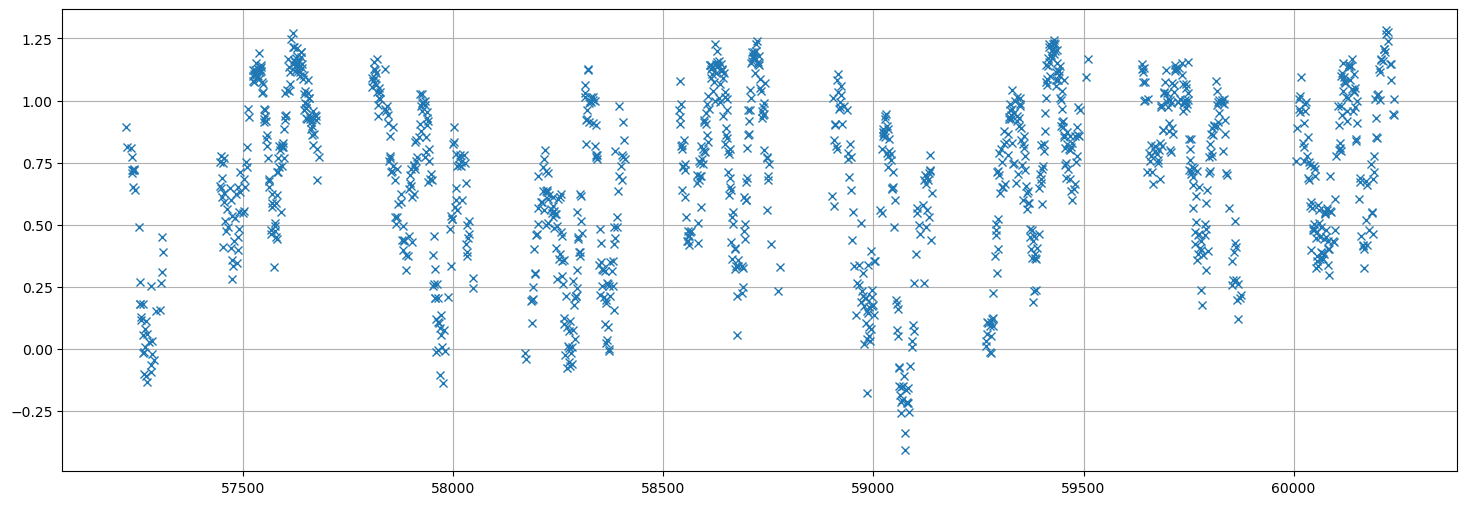

In [11]:
plt.figure(figsize=(18, 6))
plt.plot(t, list_vencode, linestyle='None', marker='x')
plt.grid()
plt.show()

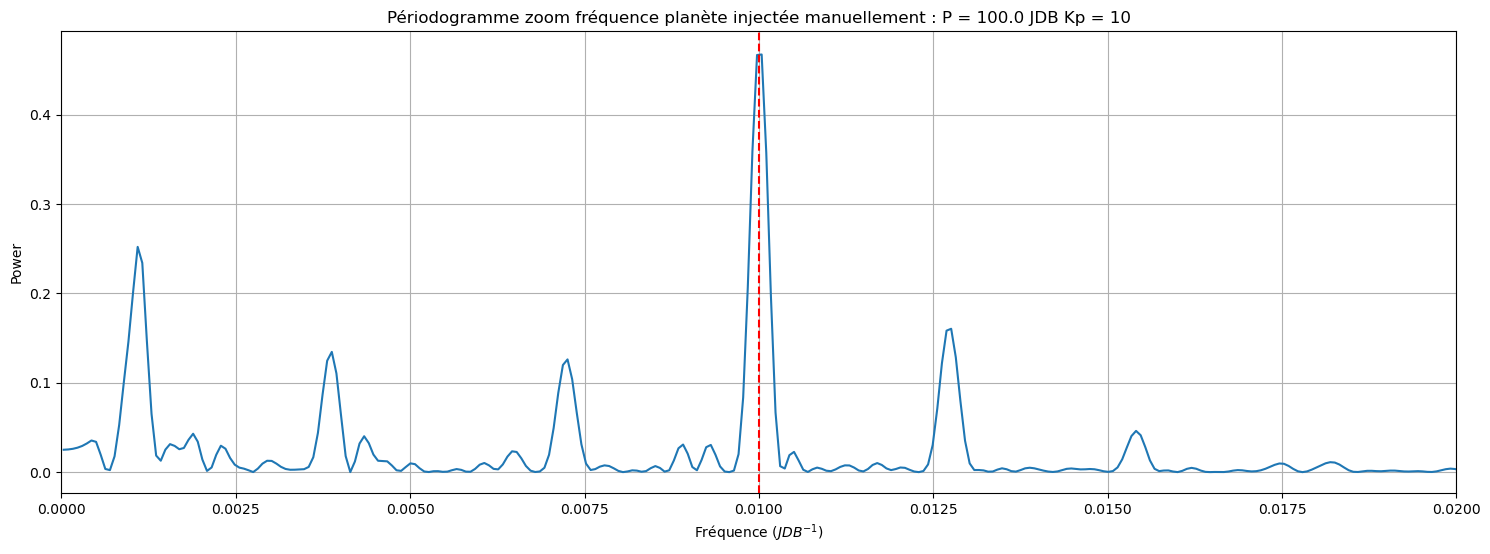

In [12]:
frequency, power = LombScargle(t, list_vencode).autopower()
%matplotlib inline
plt.figure(figsize=(18, 6))
plt.title(f'Périodogramme zoom fréquence planète injectée manuellement : P = {dataset.P:.1f} JDB Kp = 10')
plt.ylabel('Power')
plt.xlabel('Fréquence ($JDB^{-1}$)')
plt.plot(frequency, power)
plt.xlim(1/dataset.P-0.01, 1/dataset.P+0.01)
plt.axvline(x=1/dataset.P, color='r', linestyle='dashed')
plt.grid()
plt.show()    

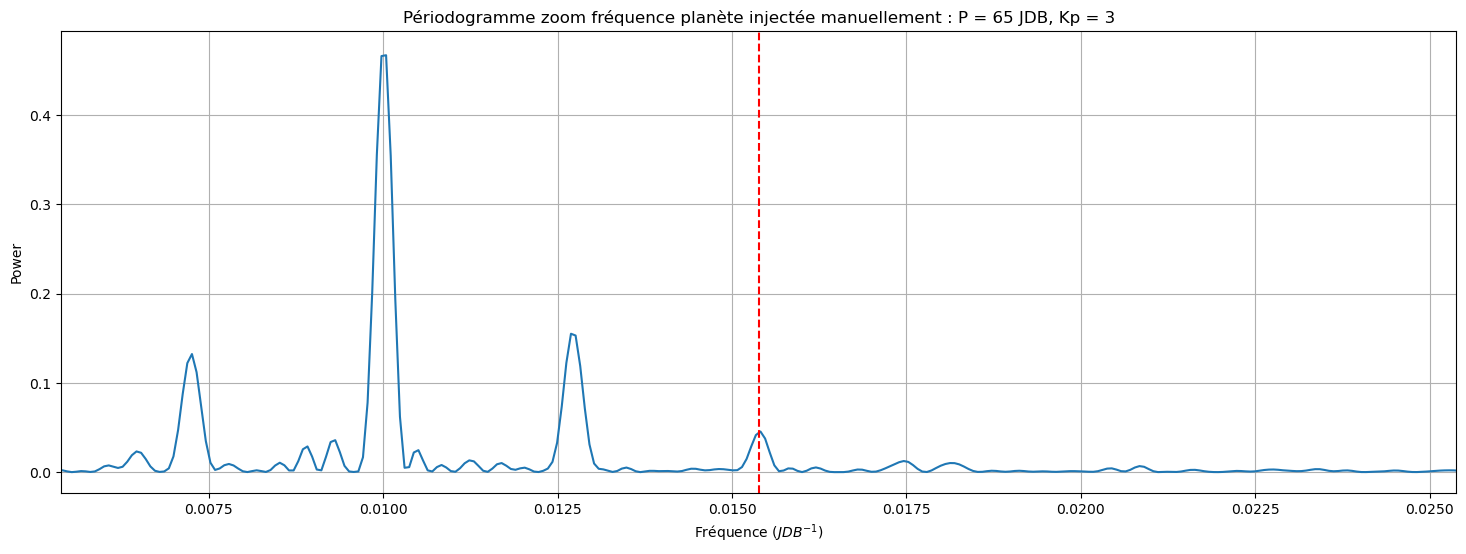

In [ ]:
frequency, power = LombScargle(t, list_vencode).autopower()
%matplotlib inline
plt.figure(figsize=(18, 6))
plt.title(f'Périodogramme zoom fréquence planète injectée manuellement : P = 65 JDB, Kp = 3')
plt.ylabel('Power')
plt.xlabel('Fréquence ($JDB^{-1}$)')
plt.plot(frequency, power)
plt.xlim(1/65-0.01, 1/65+0.01)
plt.axvline(x=1/65, color='r', linestyle='dashed')
plt.grid()
plt.show()    

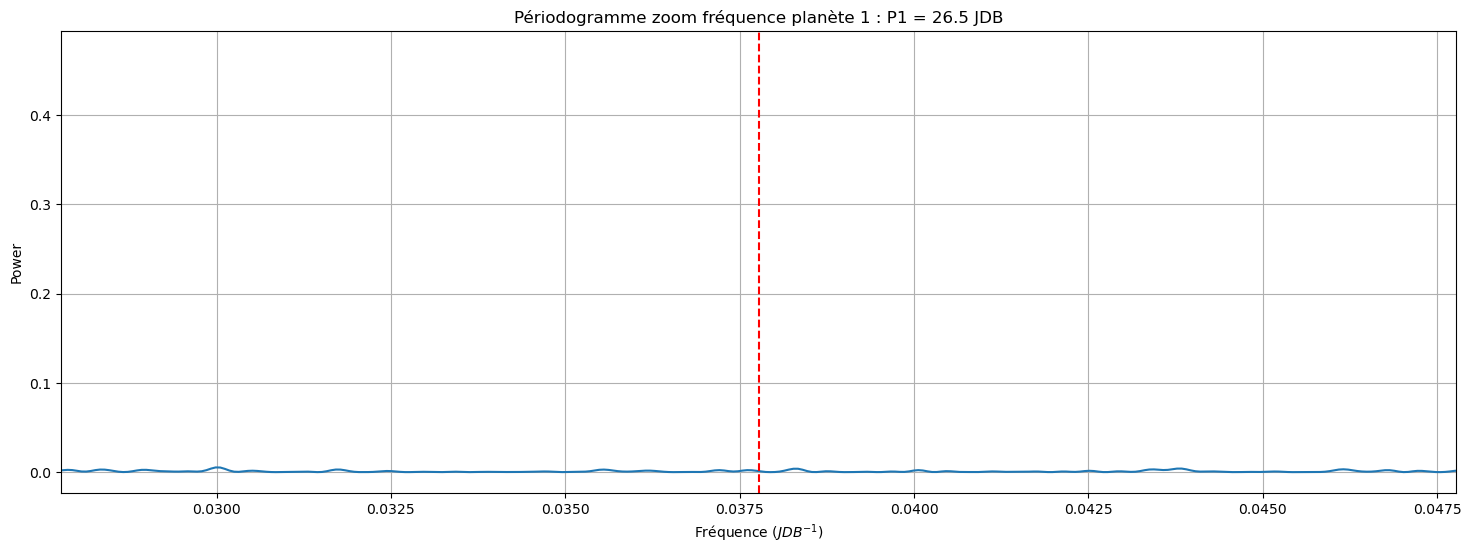

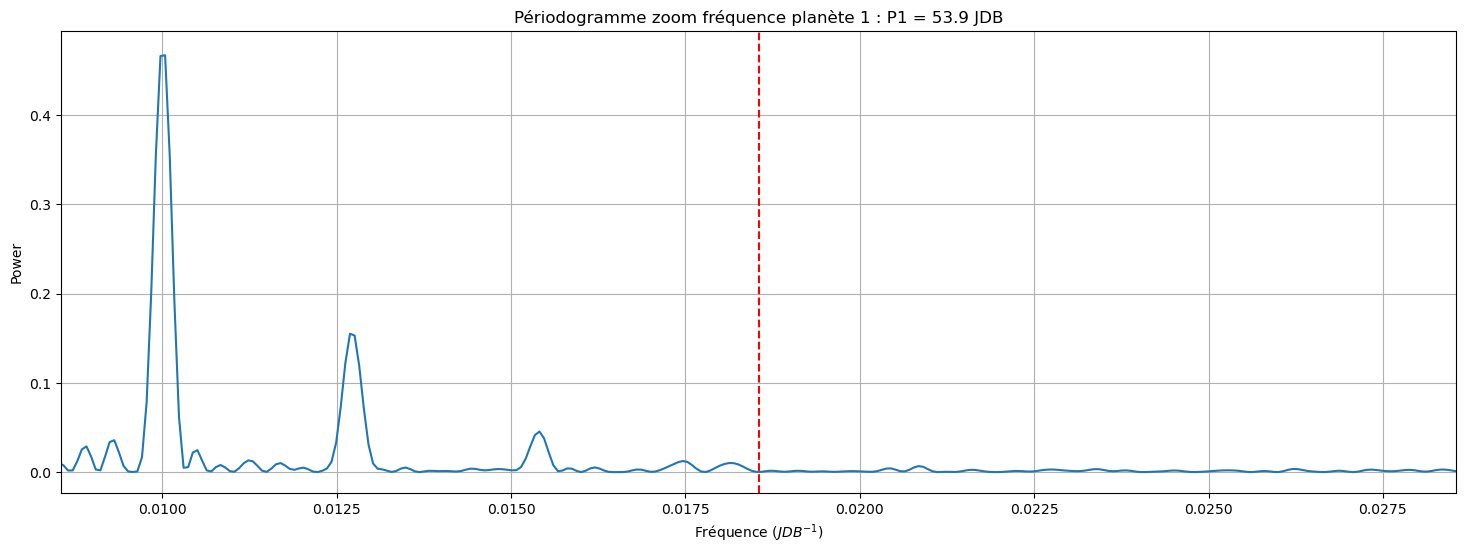

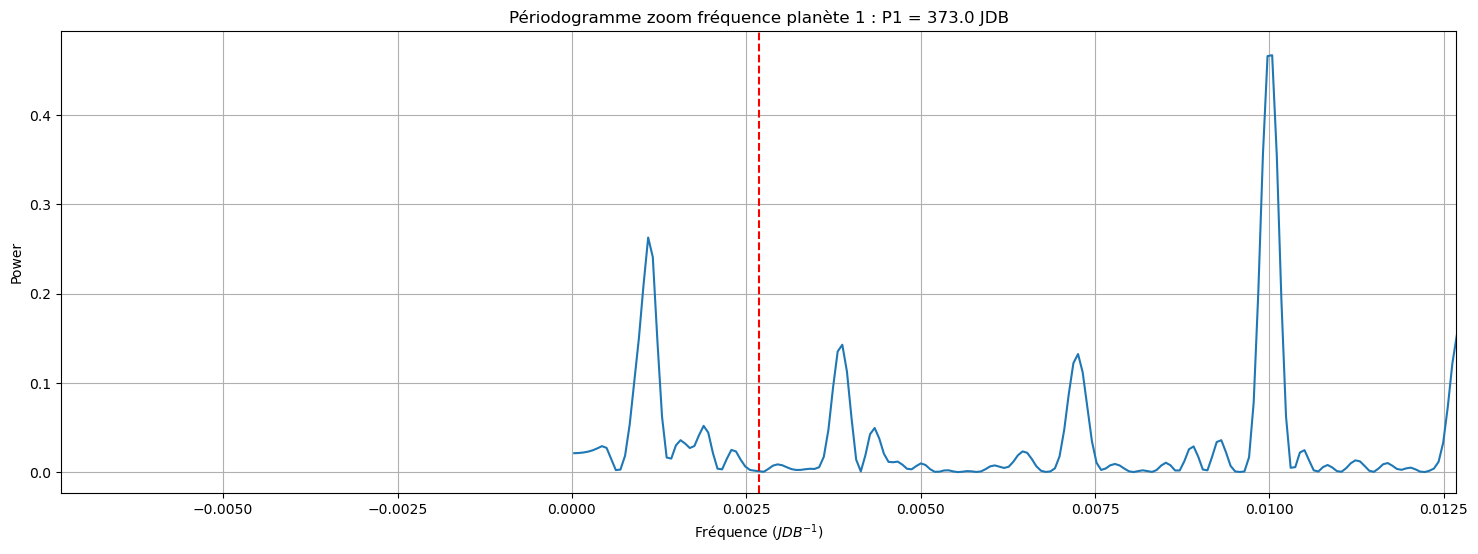

In [ ]:
f1 = 1 / 26.472536
f2 = 1 / 53.900251
f3 = 1 / 373.004812

for f in [f1, f2, f3]:
    plt.figure(figsize=(18, 6))
    plt.title(f'Périodogramme zoom fréquence planète 1 : P1 = {1/f:.1f} JDB')
    plt.ylabel('Power')
    plt.xlabel('Fréquence ($JDB^{-1}$)')
    plt.plot(frequency, power)
    plt.xlim(f-0.01, f+0.01)
    plt.axvline(x=f, color='r', linestyle='dashed')
    plt.grid()
    plt.show()